In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [3]:
np.random.seed(33)
tf.random.set_seed(33)

In [4]:
df = pd.read_csv(r'C:\Users\lmbmo\Documents\Personal\Tutorials and courses\Machine-Learning\dataset\AirlineTweets.csv')

In [5]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
df =  df[['airline_sentiment','text']]

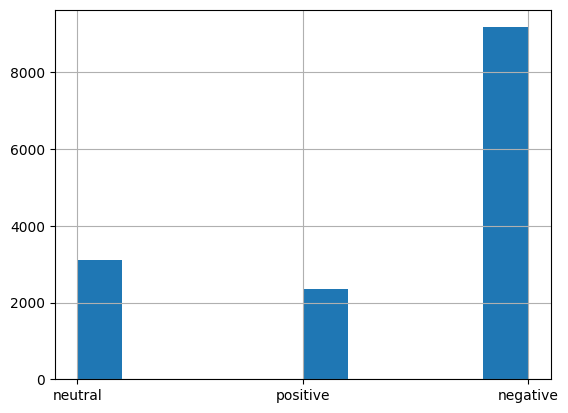

In [8]:
df['airline_sentiment'].hist();

In [9]:
df = df[df['airline_sentiment']!= 'neutral'].copy()

In [10]:
target_map = {'positive': 1, 'negative': 0}
df['target'] = df['airline_sentiment'].map(target_map)

In [11]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [12]:
df_train, df_test = train_test_split(df, random_state= 33)

In [13]:
vectorizer = TfidfVectorizer(max_features=2000)
X_train = vectorizer.fit_transform(df_train['text'])
X_test = vectorizer.transform(df_test['text'])

In [15]:
# data must not be a sparse matrix before passing into tensorflow
X_train = X_train.toarray()
X_test = X_test.toarray()

In [16]:
Y_train = df_train['target']
Y_test = df_test['target']

In [17]:
#input dimension
D = X_train.shape[1]

In [18]:
#build model
i = Input(shape = (D, ))
x = Dense(1)(i) #sigmoid included in loss

In [20]:
model = Model(i, x)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1)                 2001      
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(
    loss = BinaryCrossentropy(from_logits=True),
    optimizer = Adam(learning_rate = 0.01),
    metrics = ['accuracy']
)

In [23]:
r = model.fit(
    X_train, Y_train,
    validation_data = (X_test, Y_test),
    epochs = 40,
    batch_size = 128
)

Epoch 1/40
68/68 [==============================] - 1s 7ms/step - loss: 0.4982 - accuracy: 0.7957 - val_loss: 0.4108 - val_accuracy: 0.7938
Epoch 2/40
68/68 [==============================] - 0s 3ms/step - loss: 0.3720 - accuracy: 0.7994 - val_loss: 0.3536 - val_accuracy: 0.8073
Epoch 3/40
68/68 [==============================] - 0s 4ms/step - loss: 0.3189 - accuracy: 0.8210 - val_loss: 0.3154 - val_accuracy: 0.8306
Epoch 4/40
68/68 [==============================] - 0s 3ms/step - loss: 0.2817 - accuracy: 0.8460 - val_loss: 0.2891 - val_accuracy: 0.8475
Epoch 5/40
68/68 [==============================] - 0s 3ms/step - loss: 0.2543 - accuracy: 0.8656 - val_loss: 0.2701 - val_accuracy: 0.8617
Epoch 6/40
68/68 [==============================] - 0s 3ms/step - loss: 0.2335 - accuracy: 0.8828 - val_loss: 0.2557 - val_accuracy: 0.8739
Epoch 7/40
68/68 [==============================] - 0s 3ms/step - loss: 0.2170 - accuracy: 0.8967 - val_loss: 0.2448 - val_accuracy: 0.8843
Epoch 8/40
68/68 [==

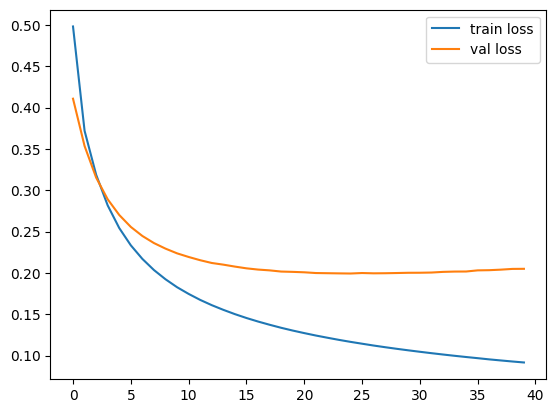

In [24]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

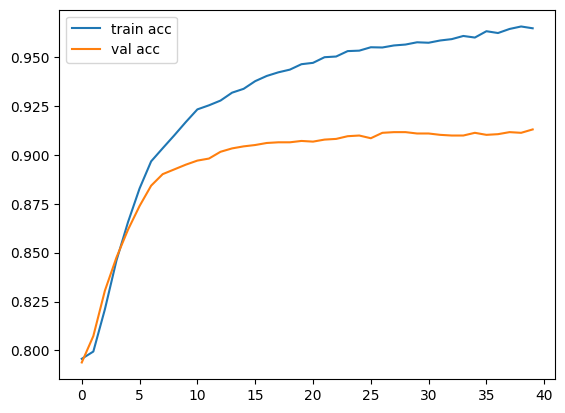

In [25]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [26]:
P_train = ((model.predict(X_train) > 0) * 1.0).flatten()
P_test = ((model.predict(X_test) > 0) * 1.0).flatten()

91/91 [==============================] - 0s 1ms/step


In [27]:
cm = confusion_matrix(Y_train, P_train, normalize='true')
cm

array([[0.99114273, 0.00885727],
       [0.08710407, 0.91289593]])

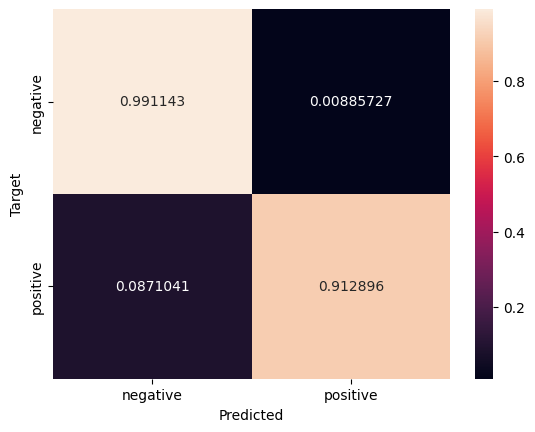

In [28]:
def plot_cm(cm):
    classes = ['negative', 'positive']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sns.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

plot_cm(cm)

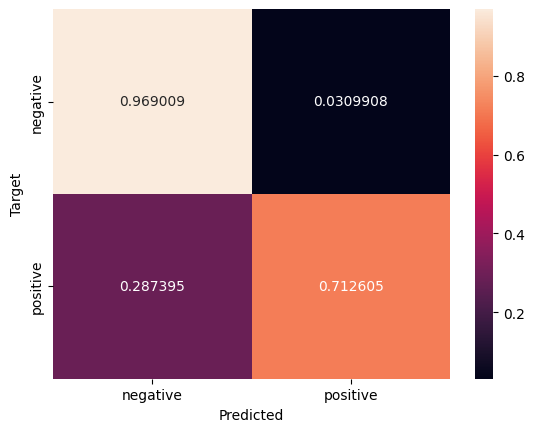

In [29]:
cm_test = confusion_matrix(Y_test, P_test, normalize='true')
plot_cm(cm_test)

In [30]:
Pr_train = model.predict(X_train)
Pr_test = model.predict(X_test)
print("Train AUC:", roc_auc_score(Y_train, Pr_train))
print("Test AUC:", roc_auc_score(Y_test, Pr_test))

91/91 [==============================] - 0s 1ms/step
Train AUC: 0.9948810862093774
Test AUC: 0.956295185031673


In [31]:
print("Train F1:", f1_score(Y_train, P_train))
print("Test F1:", f1_score(Y_test, P_test))

Train F1: 0.9375544583212315
Test F1: 0.7779816513761468


In [32]:
model.layers

In [33]:
model.layers[1].get_weights()

[array([[-3.4336889],
        [ 2.097316 ],
        [-1.689024 ],
        ...,
        [ 1.1097178],
        [ 1.1866271],
        [-2.3652573]], dtype=float32),
 array([-0.19231732], dtype=float32)]

In [34]:
w = model.layers[1].get_weights()[0]

In [35]:
word_index_map = vectorizer.vocabulary_
word_index_map

{'united': 1846,
 'have': 855,
 'talked': 1711,
 'to': 1770,
 'them': 1737,
 'on': 1253,
 'standby': 1651,
 'for': 751,
 'tomorrow': 1775,
 'but': 285,
 'it': 965,
 'doesn': 559,
 'look': 1065,
 'good': 815,
 'may': 1111,
 'stay': 1661,
 'here': 874,
 'till': 1762,
 'friday': 769,
 'amp': 136,
 'that': 1733,
 'not': 1221,
 'can': 299,
 'we': 1912,
 'get': 798,
 'an': 137,
 'explanation': 661,
 'why': 1941,
 'from': 774,
 'houston': 901,
 'has': 851,
 'been': 231,
 'delayed': 492,
 'now': 1231,
 're': 1424,
 'hearing': 865,
 'crew': 452,
 'about': 68,
 'cancelled': 300,
 'flightlations': 729,
 'usairways': 1866,
 'hold': 883,
 '23': 25,
 'all': 118,
 'because': 229,
 'they': 1741,
 'won': 1954,
 'let': 1030,
 'me': 1116,
 'use': 1869,
 'companion': 391,
 'voucher': 1889,
 'online': 1258,
 'http': 907,
 'co': 376,
 'southwestair': 1635,
 'my': 1191,
 'flight': 722,
 'was': 1901,
 'flighted': 726,
 'and': 138,
 'times': 1765,
 'are': 165,
 'long': 1063,
 'leg': 1025,
 'with': 1950,
 'you'

In [39]:
w[725, 0]

0.31738484

In [36]:
# let's look at the weights for each word
# try it with different threshold values!
threshold = 2

print("Most positive words:")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = w[index, 0]
    if weight > threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: -x[1])
for i in range(10):
  word, weight = word_weight_tuples[i]
  print(word, weight)

Most positive words:
thank 9.59107
thanks 9.496351
great 7.996582
awesome 6.861714
love 6.8460655
kudos 6.7973185
excellent 6.6346374
worries 6.5723934
wonderful 6.4534116
amazing 6.432428


In [37]:
print("Most negative words:")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = w[index, 0]
    if weight < -threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: x[1])
for i in range(10):
  word, weight = word_weight_tuples[i]
  print(word, weight)

Most negative words:
worst -8.776844
paid -7.61737
nothing -7.594361
not -7.2236633
disappointed -6.81938
real -6.7692127
rude -6.549523
until -6.532847
hours -6.5283875
fail -6.512013
